**Objective**: Study possible anomalies in data of client's transactions.  <br>

**Author**: Luis Marcos López

In [289]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [508]:
data = pd.read_csv("transaction_data.csv")
data.head()
# data[data['client_id'] == 143171]


,date,amount,client_id
0,2017-05-24,63.058251,975386
1,2021-08-29,118.253665,955735
2,2020-08-23,102.693555,975386
3,2019-04-27,78.942714,160736
4,2017-10-20,56.949652,143171


In [461]:
# data.info()
# data['date'] = data['date'].apply(lambda x: x[:-3])



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22239 entries, 0 to 22238
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       22239 non-null  object 
 1   amount     22239 non-null  float64
 2   client_id  22239 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 521.4+ KB


In [510]:
data.info()
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data['date'] = data['date'].dt.strftime('%Y-%m')
data.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22239 entries, 0 to 22238
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       22239 non-null  datetime64[ns]
 1   amount     22239 non-null  float64       
 2   client_id  22239 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 521.4 KB
2021-12-07 00:00:00


date            60
amount       22239
client_id       14
dtype: int64

In [507]:
data.head()
print(data.date.min())

2017-01


Will focus on the anomalies in transactions of individual clients and not as a whole, because different clients may have different transaction behavior. So, to really understand if there is an anomaly in a client transaction history we have to consider his/her particular behaviour. 

In [471]:
print(data.client_id.unique())
n_clients = len(data.client_id.unique())

[975386 955735 160736 143171 986180 427729 170552 457867 588453 955698
 966823 169440 589131 499072]


In [496]:
df = data.groupby(by=['client_id', data.date], as_index = False).size() # also consider median and mean sum
df.head()

,client_id,date,size
0,143171,2017-01,6
1,143171,2017-02,27
2,143171,2017-03,27
3,143171,2017-04,27
4,143171,2017-05,28


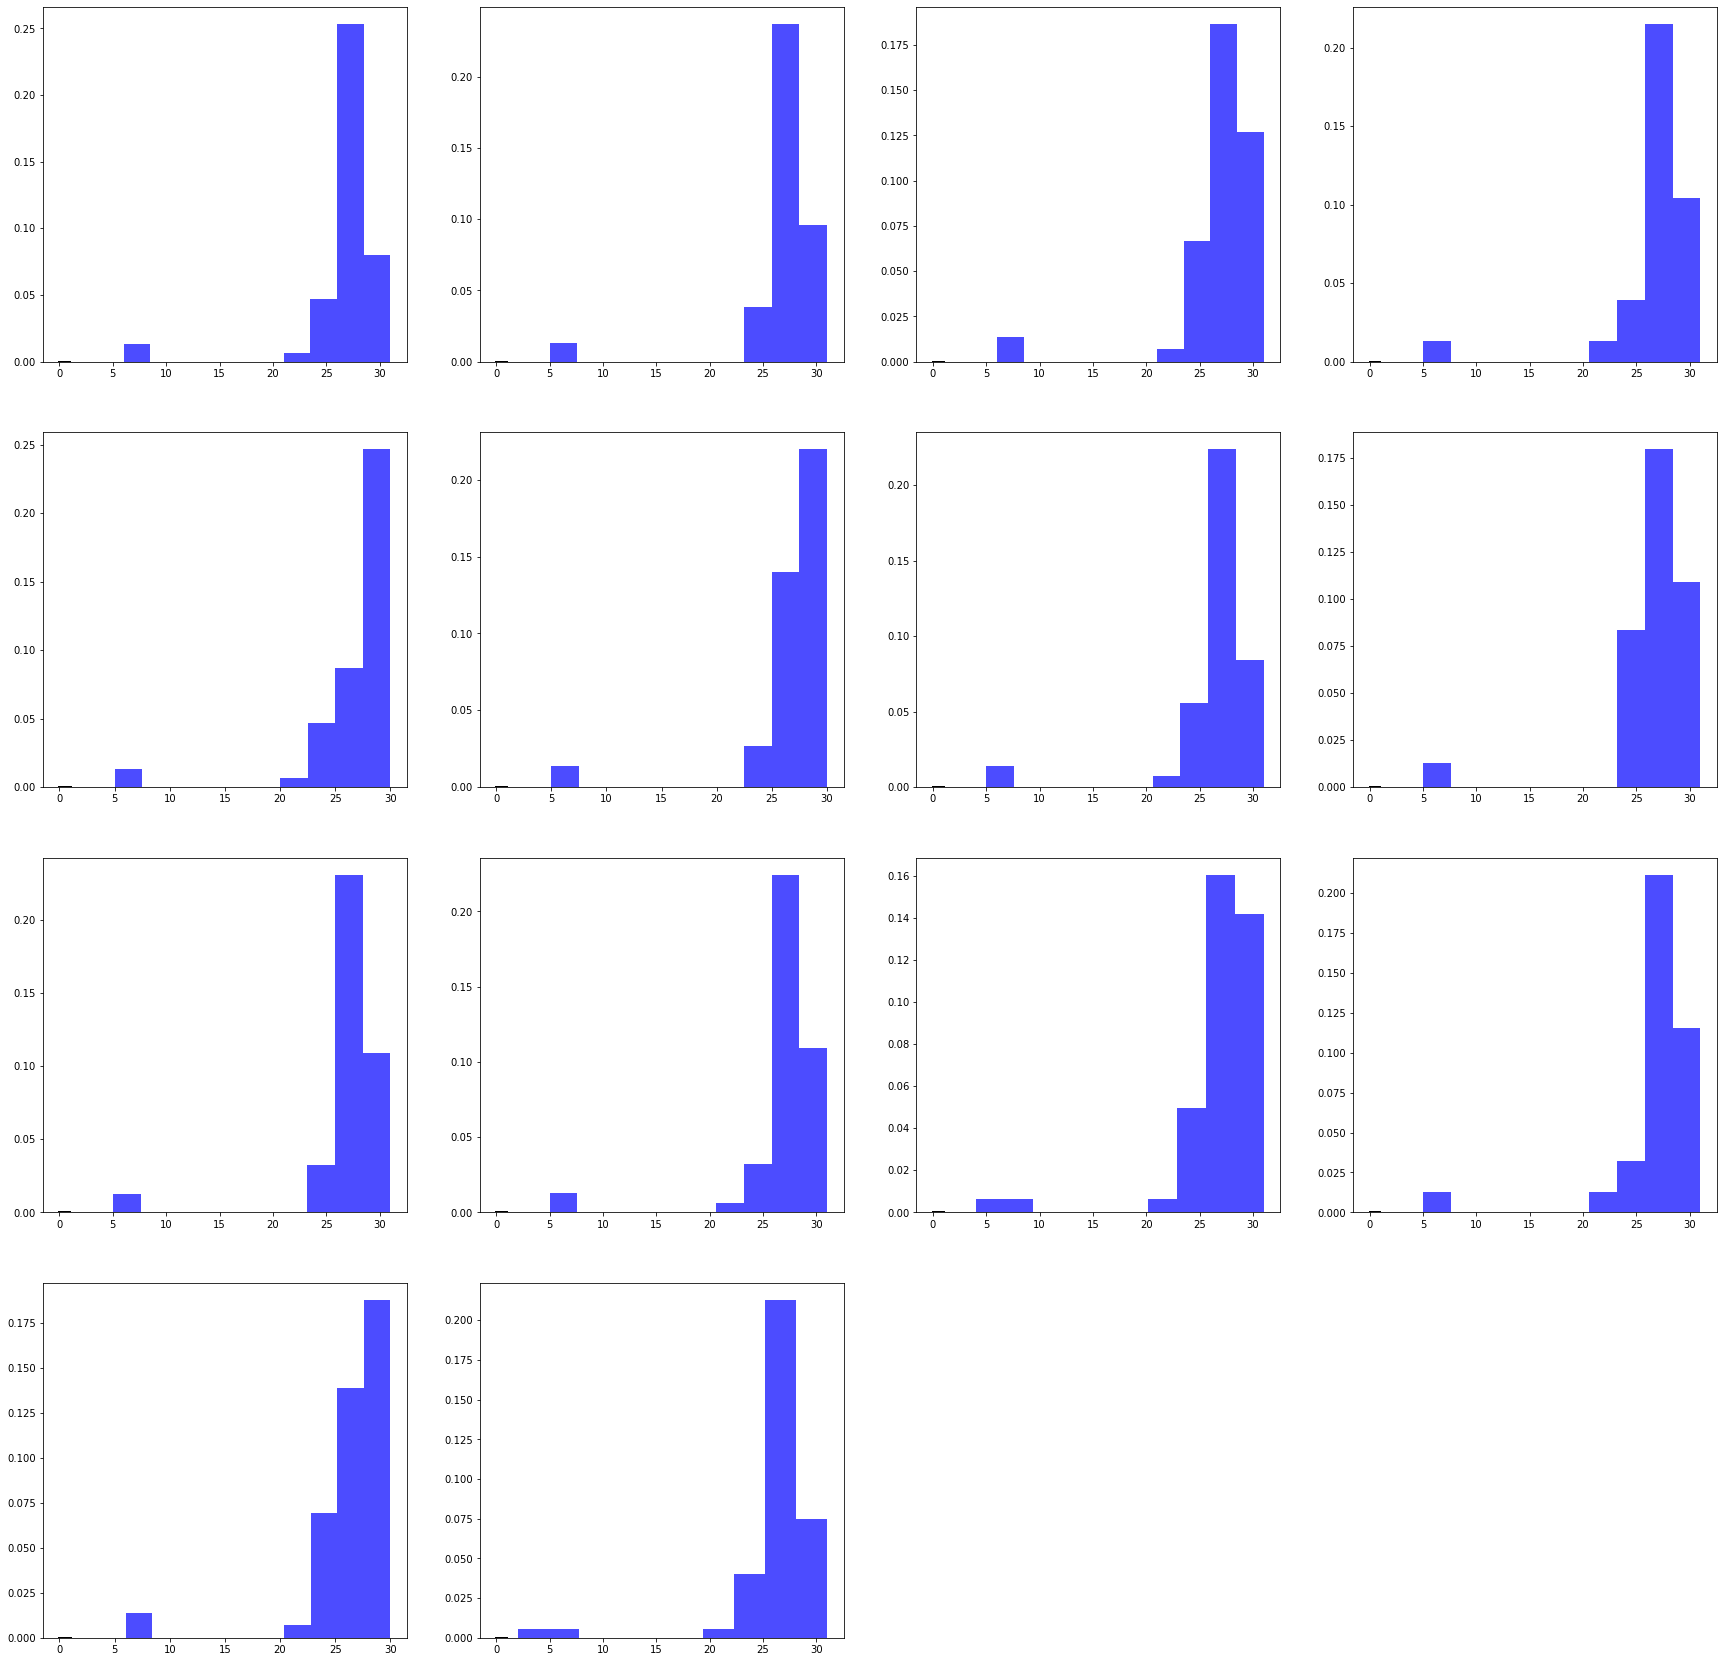

In [500]:

# data_to_plot = df[df['client_id'] == 160736]['amount']
# mu, std = norm.fit(data_to_plot)
# # Plot the histogram.
# plt.hist(data_to_plot, density=True, alpha=0.7, color='b')

# # Plot the PDF.
# xmin, xmax = plt.xlim()
# x = np.linspace(xmin, xmax, 100)
# p = norm.pdf(x, mu, std)
# plt.plot(x, p, 'k', linewidth=2)
# plt.title('Client {}'.format(c))
# plt.show()



fig, axes = plt.subplots(nrows= 4, ncols=4, figsize = (30,30))

for i, ax in enumerate(axes.flat):
    if i == 14:
        break
    c = df.client_id.unique()[i]
    data_to_plot = df[df['client_id'] == c]['size']
    mu, std = norm.fit(data_to_plot)
    # Plot the histogram.
    ax.hist(data_to_plot, density=True, alpha=0.7, color='b')

    # Plot the PDF.
    xt = plt.xticks()[0]  
    xmin, xmax = min(xt), max(xt) 
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax.plot(x, p, 'k', linewidth=2)
    # ax.title('Client {}'.format(c))

fig.delaxes(axes[3][3])
fig.delaxes(axes[3][2])
plt.show()


First inspection by scatter plots

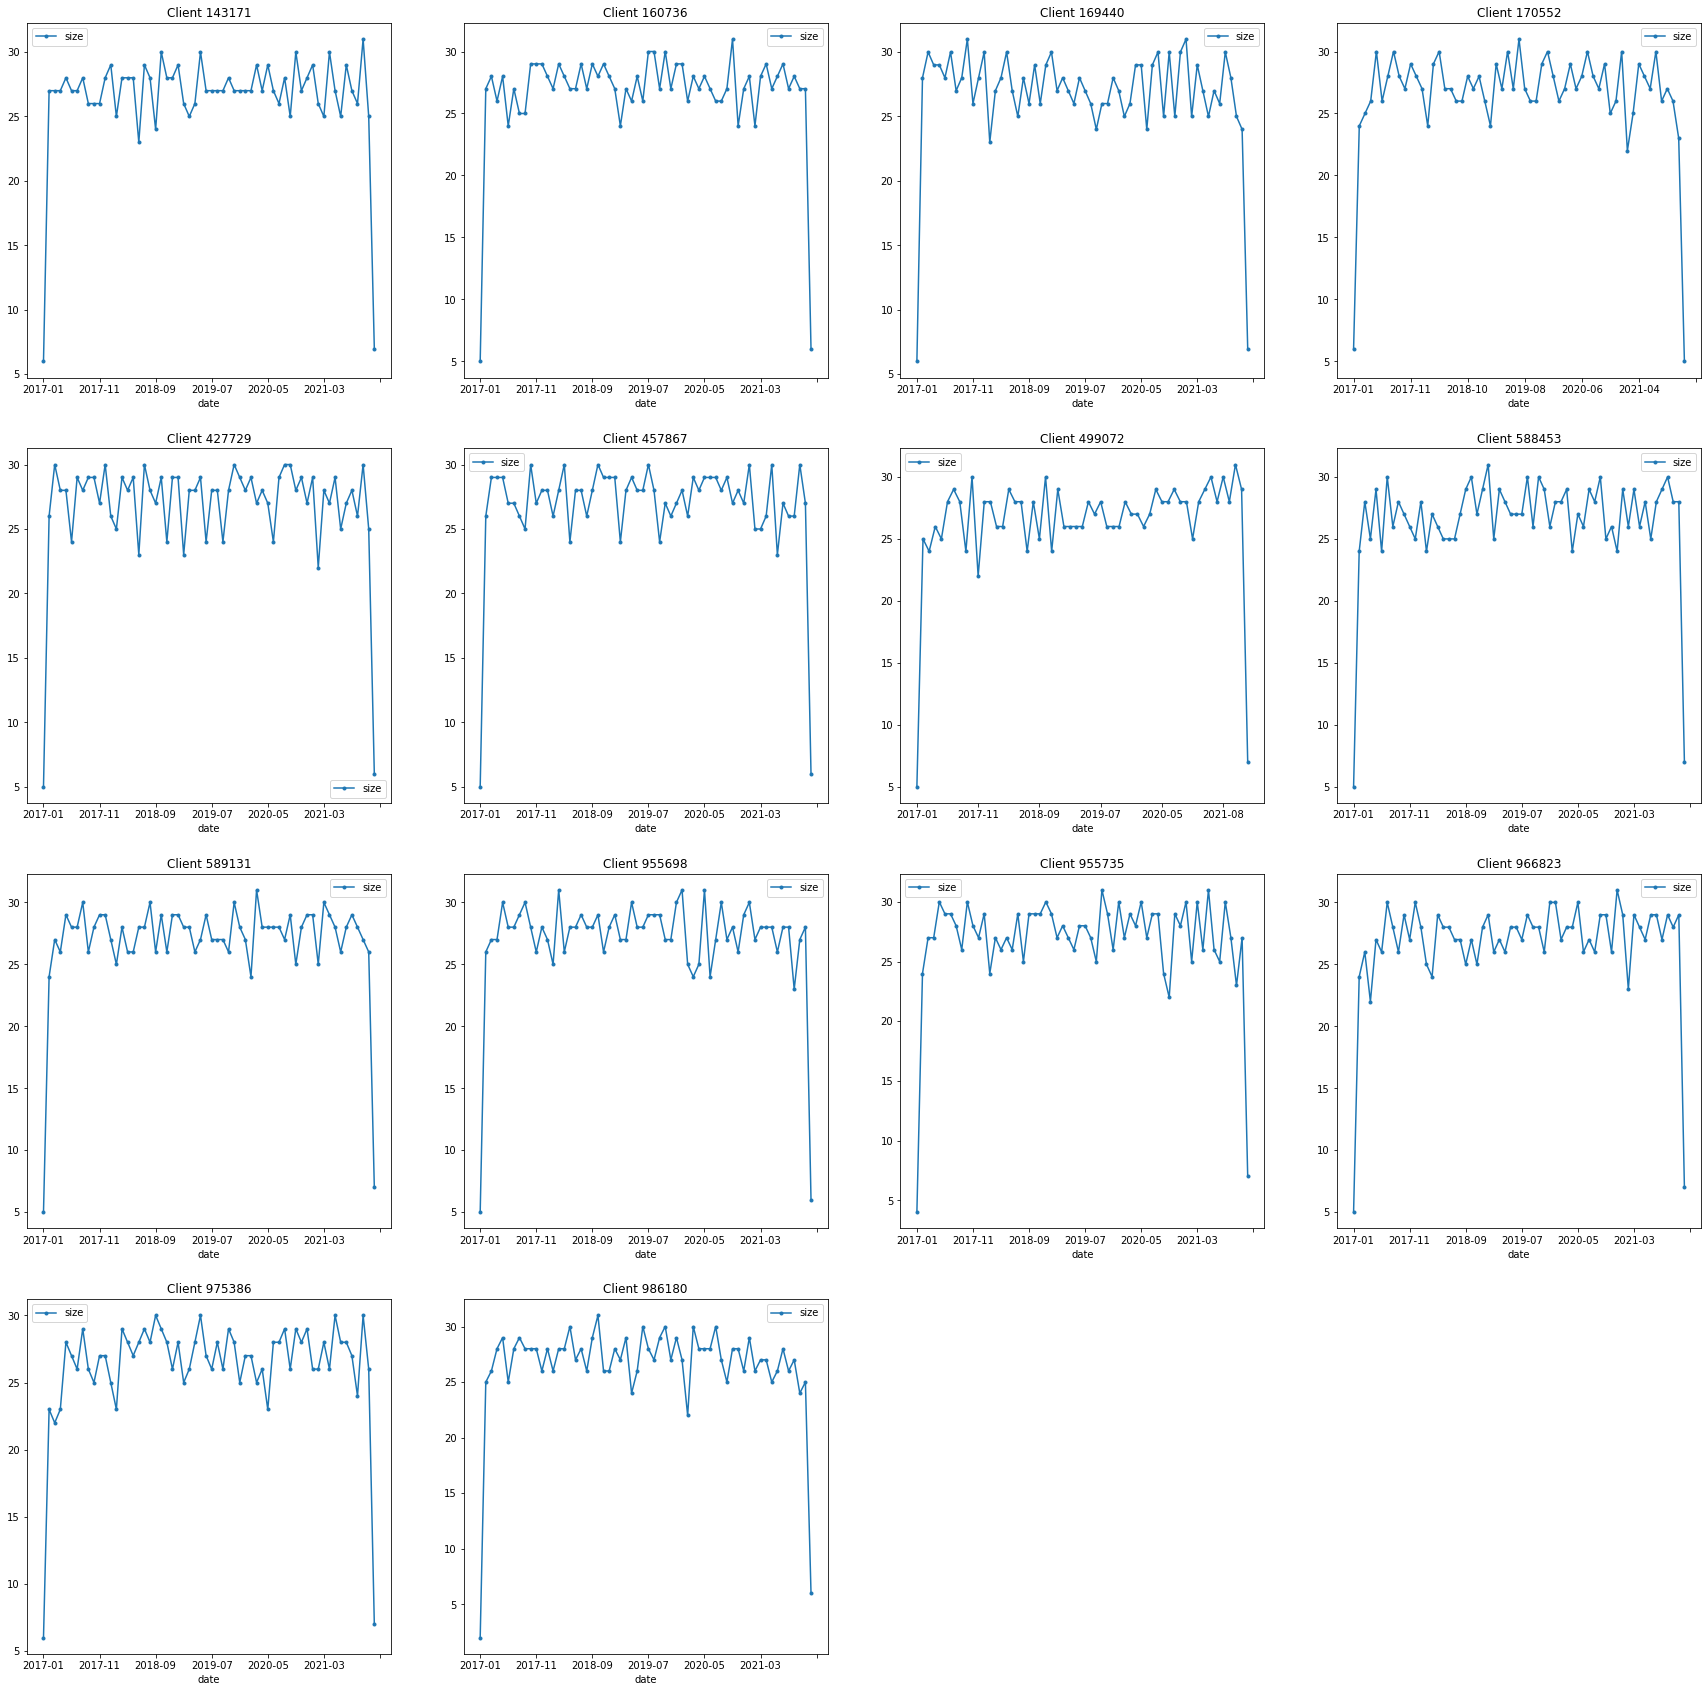

In [501]:
fig, axes = plt.subplots(nrows= 4, ncols=4, figsize = (30,30))

for i, ax in enumerate(axes.flat):
    if i == n_clients:
        break
    c = df.client_id.unique()[i]
    df[df['client_id'] == c].plot(x= 'date', y= 'size', ax=ax, marker='.')
    ax.set_title('Client {}'.format(c))

fig.delaxes(axes[3][3])
fig.delaxes(axes[3][2])
plt.show()

# Boxplots

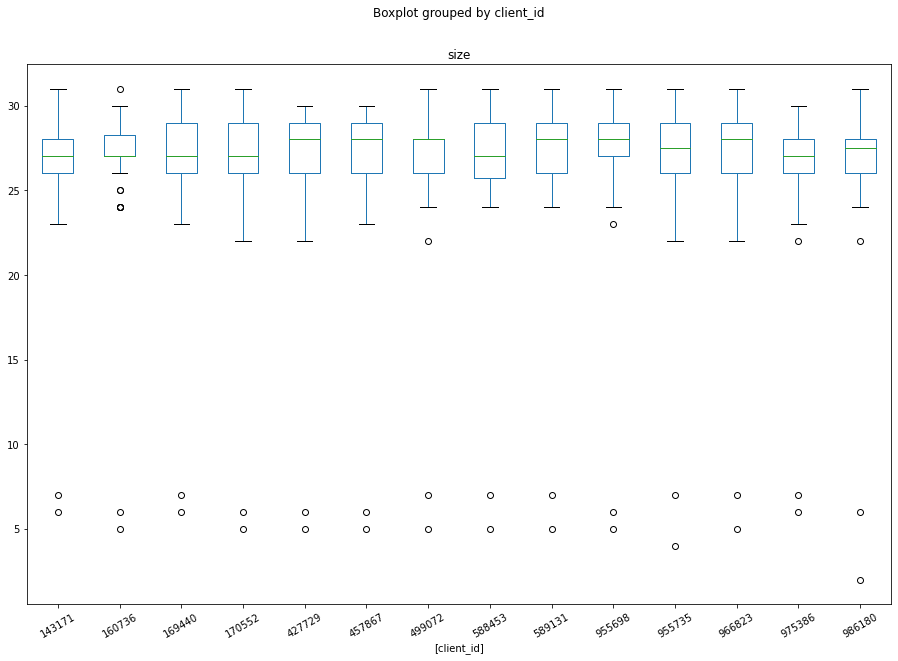

In [502]:
boxplot = df.boxplot(by='client_id', grid = False, rot = 30, figsize=(15,10))

Find those outliers

In [299]:
ns_client = [143171, 499072]
for n_client in ns_client:
    client = df[df['client_id'] == n_client]
    Q1 = client['amount'].quantile(0.25)
    Q3 = client['amount'].quantile(0.75)
    IQR = Q3 - Q1

    filter = (client['amount'] < Q1 - 1.5 * IQR) | (client['amount'] > Q3 + 1.5 *IQR)
    display(client.loc[filter])

,client_id,date,amount
28,143171,2019-05-01,393.577853


,client_id,date,amount
409,499072,2021-08-01,118.487418
413,499072,2021-12-01,120.087445


# Arima

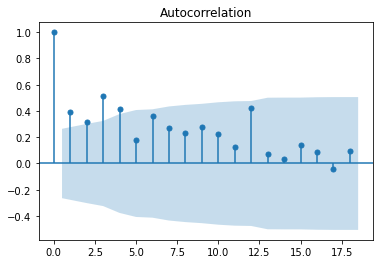

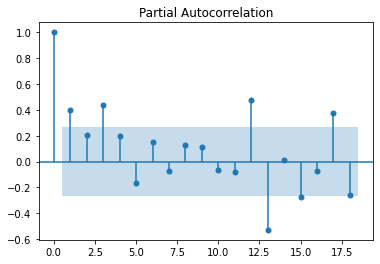

In [434]:
# from statsmodels.graphics.tsaplots import plots_acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
sp_client = df[df['client_id'] == 499072]['amount']
plot_acf(sp_client);
plot_pacf(sp_client);


c:\Users\Luis\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


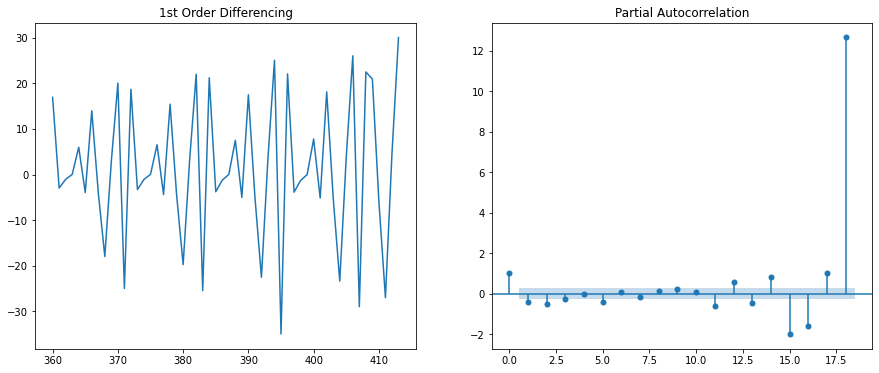

In [435]:
f = plt.figure(figsize=(15,6))
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(sp_client.diff())

ax2 = f.add_subplot(122)
plot_pacf(sp_client.diff().dropna(), ax = ax2)
plt.show()

c:\Users\Luis\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


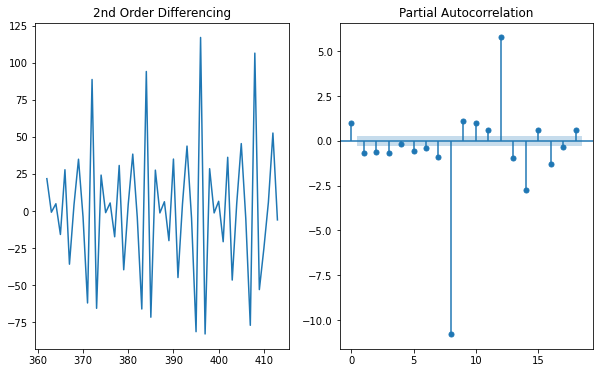

In [436]:
f = plt.figure(figsize=(10,6))
ax1 = f.add_subplot(121)
ax1.set_title('2nd Order Differencing')
ax1.plot(sp_client.diff().diff().diff())

ax2 = f.add_subplot(122)
plot_pacf(sp_client.diff().diff().diff().dropna(), ax = ax2)
plt.show()

In [437]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(sp_client.dropna())
print('p-value: ', result[1])

result = adfuller(sp_client.diff().dropna())
print('p-value: ', result[1])

result = adfuller(sp_client.diff().diff().dropna())
print('p-value: ', result[1])

p-value:  0.9972772653317342
p-value:  0.5383790899496367
p-value:  1.4827866237142902e-05


In [438]:
# from statsmodels.tsa.arima_model import ARIMA
# arima_model = ARIMA(sp_client, order=(1,1,1, 13))
# model = arima_model.fit()
# print(model.summary())


from statsmodels.tsa.statespace.sarimax import SARIMAX
arima_model = SARIMAX(sp_client, order=(2,0,1), seasonal_order = (1,0,3,13))
model = arima_model.fit()
print(model.summary())

c:\Users\Luis\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
c:\Users\Luis\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Luis\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Luis\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting par

                                         SARIMAX Results                                          
Dep. Variable:                                     amount   No. Observations:                   55
Model:             SARIMAX(2, 0, 1)x(1, 0, [1, 2, 3], 13)   Log Likelihood                -215.940
Date:                                    Sat, 26 Nov 2022   AIC                            447.879
Time:                                            18:25:38   BIC                            463.938
Sample:                                                 0   HQIC                           454.089
                                                     - 55                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9292      0.312      2.981      0

c:\Users\Luis\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


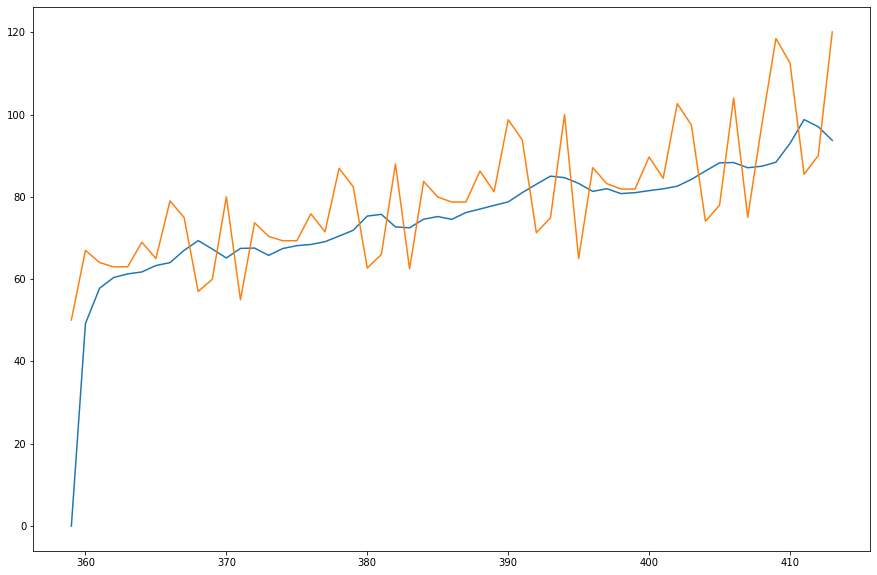

In [439]:
# yhat = model.predict(start=len(data), end=len(data))
# model.plot_predict(dynamic=False)
# plt.show()

# yhat = model.forecast()
plt.figure(figsize=(15,10))
sarima = model.get_prediction()
sarima_mean = sarima.predicted_mean
plt.plot(sarima_mean.index, sarima_mean, label = 'sarima')
plt.plot(sp_client, label='observed')

# model.plot_predict(dynamic=False)
# plt.show()

# Auto Arima

In [398]:
! pip install pmdarima


In [399]:
# from pmdarima.arima import auto_arima
import pmdarima
# my_client = df[df['client_id'] == 143171]
# train = my_client.sort_values('date')[:-8]
# test = my_client.sort_values('date')[-8:]


# # train, test = train_test_split(sp_client, train_size=0.80)

# model = auto_arima(train, seasonal=True, m=4)

# forecasts = model.predict(test.shape[0])  # predict N steps into the future
# mape = MAPE(test.values.reshape(1,-1)[0], forecasts)

ImportError: cannot import name '__version__' from 'statsmodels._version' (c:\Users\Luis\anaconda3\lib\site-packages\statsmodels\_version.py)

In [381]:
def MAPE(y_orig, y_pred):
    MAPE = np.mean((abs(y_orig - y_pred)/y_orig)  * 100.)
    return MAPE

In [ ]:
# upper bound and lower bound using MAPE
predicted_ub = forecast + (mape * 0.01 * forecast)
predicted_lb = forecast - (mape * 0.01 * forecast)
plot.fill_between(date, predicted_lb, predicted_ub, alpha = 0.3, color = 'red')
plt.plot(date, test.values.reshape(1,-1)[0], color = 'black')
plt.legend(['Actual Test', 'Prediction Band'])
plt.xlabel('Time Period')
plt.xticks(rotation=45)
plt.ylabel('Normalized Profit')

# Isolation forest

In [411]:
from sklearn.ensemble import IsolationForest

model =  IsolationForest(contamination=0.005)


model.fit(my_client[['amount']])

IsolationForest(contamination=0.005)

In [412]:
my_client['outliers']=pd.Series(model.predict(my_client[['amount']])).apply(lambda x: 'yes' if (x == -1) else 'no' )

C:\Users\Luis\AppData\Local\Temp/ipykernel_25820/3126074880.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_client['outliers']=pd.Series(model.predict(my_client[['amount']])).apply(lambda x: 'yes' if (x == -1) else 'no' )


In [413]:
my_client.query('outliers=="yes"')

,client_id,date,amount,outliers
28,143171,2019-05-01,393.577853,yes


In [499]:
df2 = pd.DataFrame([[1, 2, 3, 4, 100], ['A','B','C','C','C'], ['Luis', 'Laia', 'Eco', 'Luis', 'Luis']]).T
df2.columns = ['amount','letter','name']
df2



df3 = df2.groupby(by=['name', 'letter'], as_index = False).size().reset_index(name='amount') # also consider median and mean
df3

TypeError: reset_index() got an unexpected keyword argument 'name'